# PM2.5 Observations
## Group 6
### Nicholas Tam, Devansh Chopra, Steven Tsai, Xiao Jin

In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────

## Background Information
From 2010 to 2014, Beijing and a substantial part of China have suffered from chronic air pollution. The main pollutants are PM2.5, otherwise known as particulate matter, referring to tiny particles in the air with aerodynamic diameters of 2.5 micrometers (2.5 * 10^(-6) m or 2.5 μm) or less. (Inhalable Particulate Matter and Health (PM2.5 and PM10)) The presence of high concentrations of PM2.5 in Beijing from 2010 to 2014 has negatively influenced the climate, visibility, and human health, to the point that if PM2.5 concentration is particularly high, outdoor activities are suggested to be avoided to reduce the risk of respiratory diseases. PM2.5 consists of a complex mixture of solids and aerosols, with particles containing various organic and inorganic compounds, and its concentration is highly influenced by meteorological conditions such as temperature and wind speed. (Sun, Ruiling, et al, 2019)

## Dataset and Project Question
For our research project, we have selected a dataset of hourly observations of PM2.5 concentration from 1-1-2010 to 12-31-2014. This dataset was retrieved from https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data, and contains the PM2.5 data of US Embassy in Beijing, as well as the meteorological data from Beijing Capital International Airport. With this dataset, we want to understand how surrounding temperatures, cumulated wind speed and humidity in different months affect PM2.5 concentration. The result is expected to give us an insight into which situation is most optimal for outdoor activities in Beijing, such as hiking. 

## Graphs
We read the dataset into R as shown below, including a new column for humidity called HUMID (%):

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv"
pollution <- read_csv(url)
pollution[is.na(pollution)] <- 0
pollution <- mutate(pollution, HUMID = 100 - 5 * (TEMP - DEWP))
head(pollution)

Parsed with column specification:
cols(
  No = col_double(),
  year = col_double(),
  month = col_double(),
  day = col_double(),
  hour = col_double(),
  pm2.5 = col_double(),
  DEWP = col_double(),
  TEMP = col_double(),
  PRES = col_double(),
  cbwd = col_character(),
  Iws = col_double(),
  Is = col_double(),
  Ir = col_double()
)



No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,HUMID
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,2010,1,1,0,0,-21,-11,1021,NW,1.79,0,0,50
2,2010,1,1,1,0,-21,-12,1020,NW,4.92,0,0,55
3,2010,1,1,2,0,-21,-11,1019,NW,6.71,0,0,50
4,2010,1,1,3,0,-21,-14,1019,NW,9.84,0,0,65
5,2010,1,1,4,0,-20,-12,1018,NW,12.97,0,0,60
6,2010,1,1,5,0,-19,-10,1017,NW,16.10,0,0,55


### Data Splitting

In [3]:
pollution_split <- initial_split(pollution, prop=3/4, strata = pm2.5)
pollution_training <- training(pollution_split)
pollution_testing <- testing(pollution_split)
pollute_avg <- pollution_training %>%
     select(year, month, day, hour, pm2.5, DEWP, TEMP, Iws, HUMID) %>%
     group_by(year,month) %>%
     summarise(pm2.5_avg = mean(pm2.5, na.rm = TRUE),TEMP_avg = mean(TEMP, na.rm = TRUE),Iws_avg = mean(Iws, na.rm = TRUE), HUMID_avg = mean(HUMID, na.rm = TRUE))
pollute_avg

`summarise()` regrouping output by 'year' (override with `.groups` argument)



year,month,pm2.5_avg,TEMP_avg,Iws_avg,HUMID_avg
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010,1,76.48998,-6.2313297,41.303661,45.819672
2010,2,99.65936,-1.9143426,13.269761,44.601594
2010,3,91.89408,3.3770197,23.571329,44.219031
2010,4,83.33333,10.6420455,55.526932,31.107955
2010,5,85.81261,20.7110333,20.793643,35.131349
2010,6,84.30939,24.1970534,10.298564,57.090239
2010,7,124.31972,27.8436945,14.533321,64.653641
2010,8,90.98951,25.5367133,16.760769,64.763986
2010,9,79.68382,20.3621324,14.251838,64.338235


### Graphs of Temperature, Wind Speed and Relative Humidity
In our data, we use year and month, TEMP (Surrounding temperature, °C), Iws (Cumulated wind speed, m/s), and HUMID (Relative humidity, %) as three predictors to predict our outcome variable, or pm2.5 (PM 2.5, ug/m^3). For TEMP and Iws, we generate a scatterplot for both predictors to see their relationship against pm2.5. A regression line is also drawn for each scatterplot to further interpret the relationships. Next, we analyze the relationship between months in each year and pm2.5. Line plots are generated to exhibit the trend over time. For year and month, we use a facet grid of scatterplots to show the trend of PM2.5 concentration over the years and months.

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



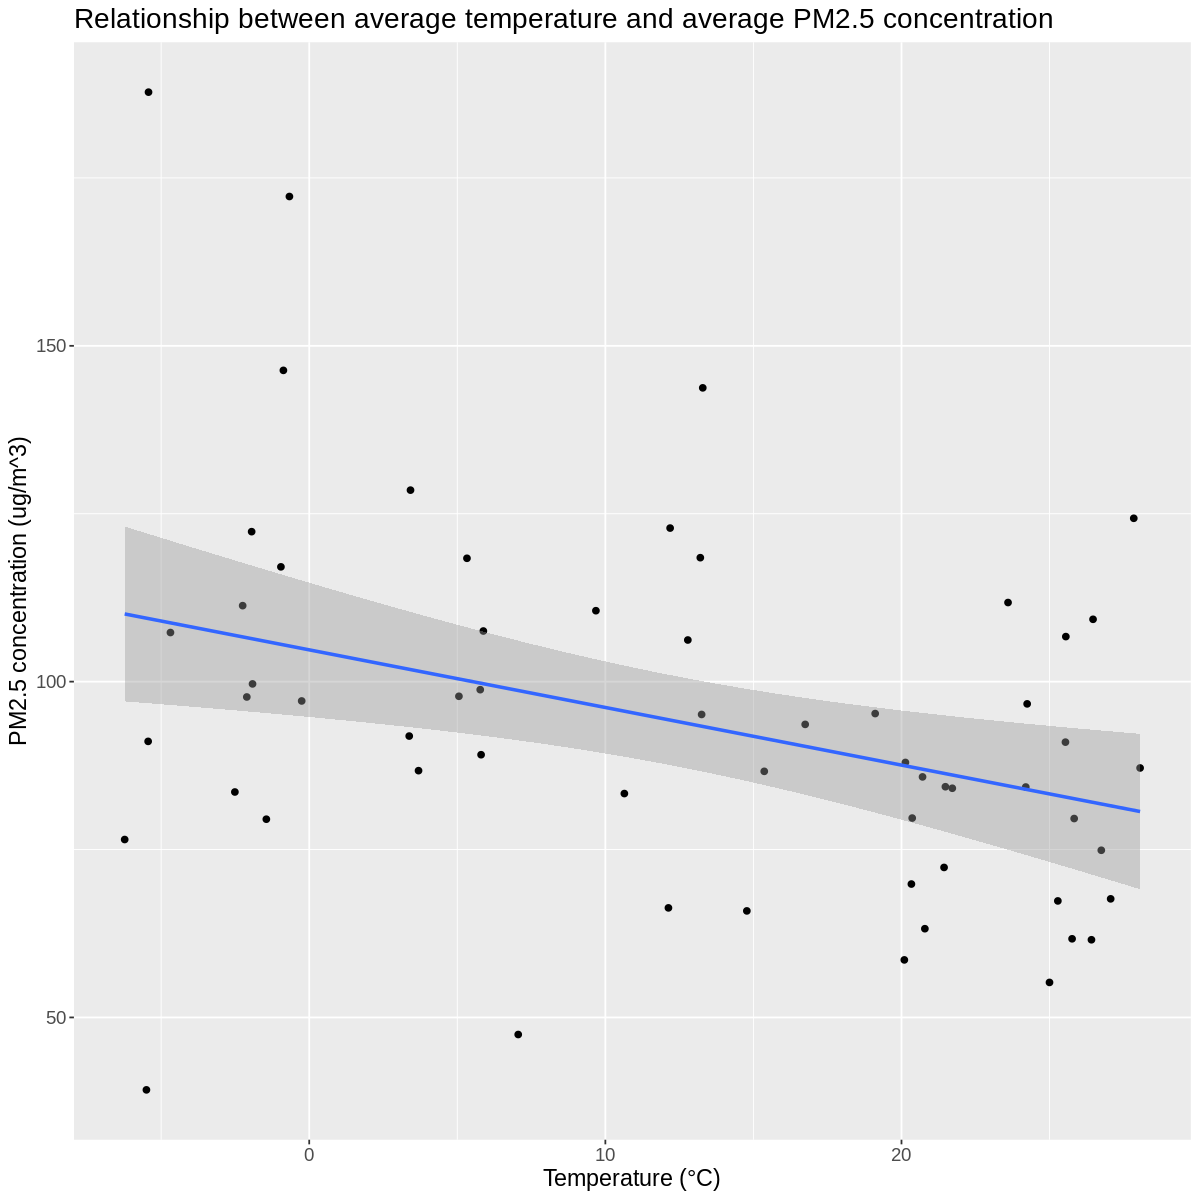

`geom_smooth()` using formula 'y ~ x'



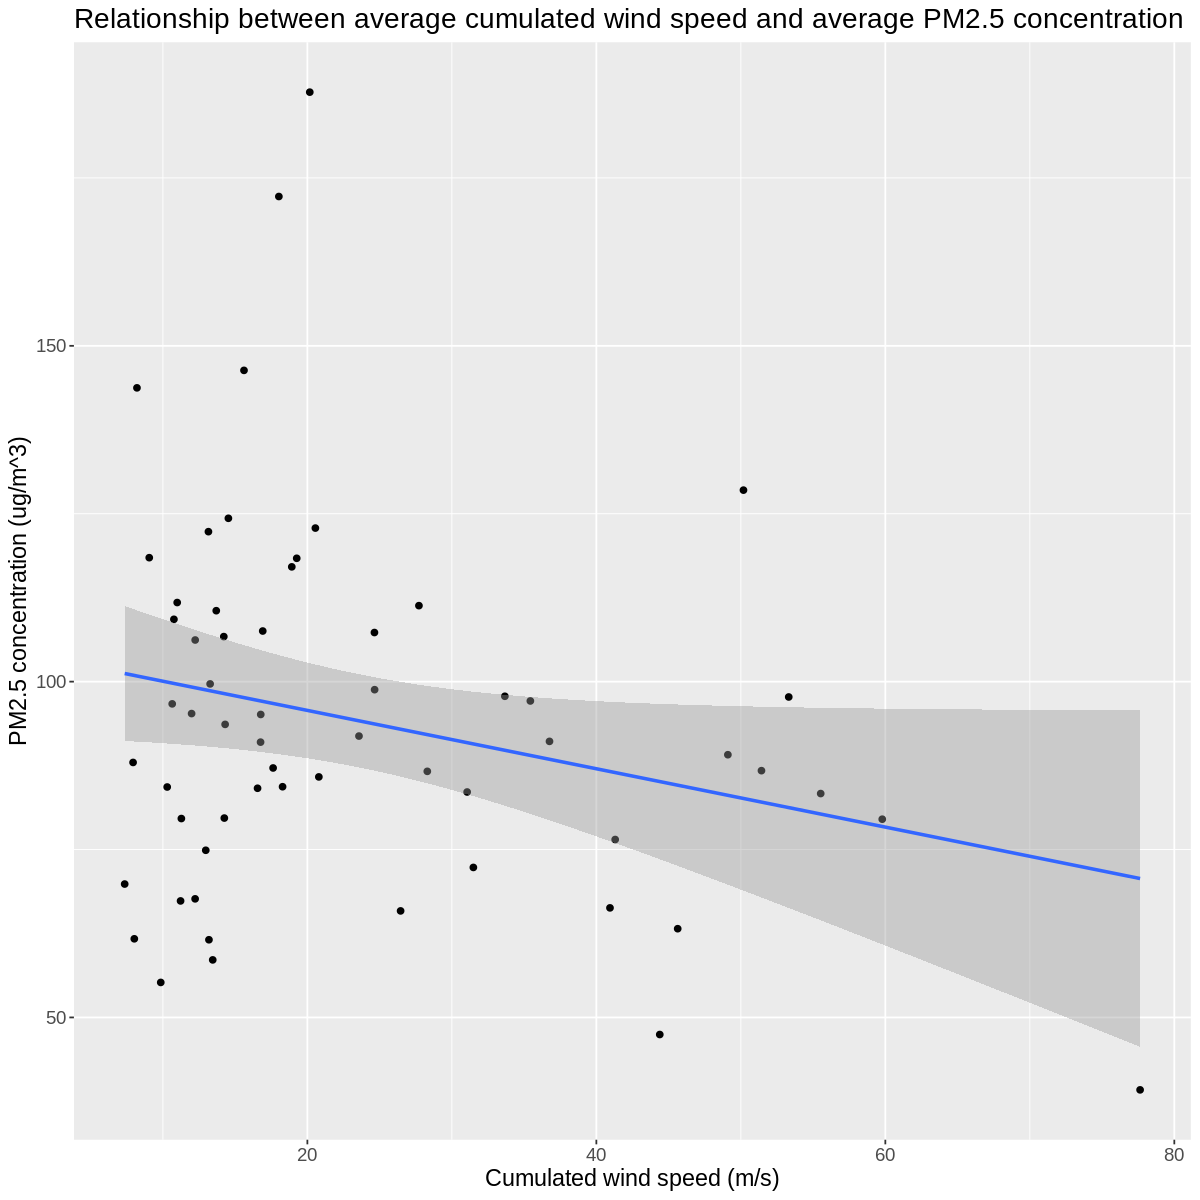

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



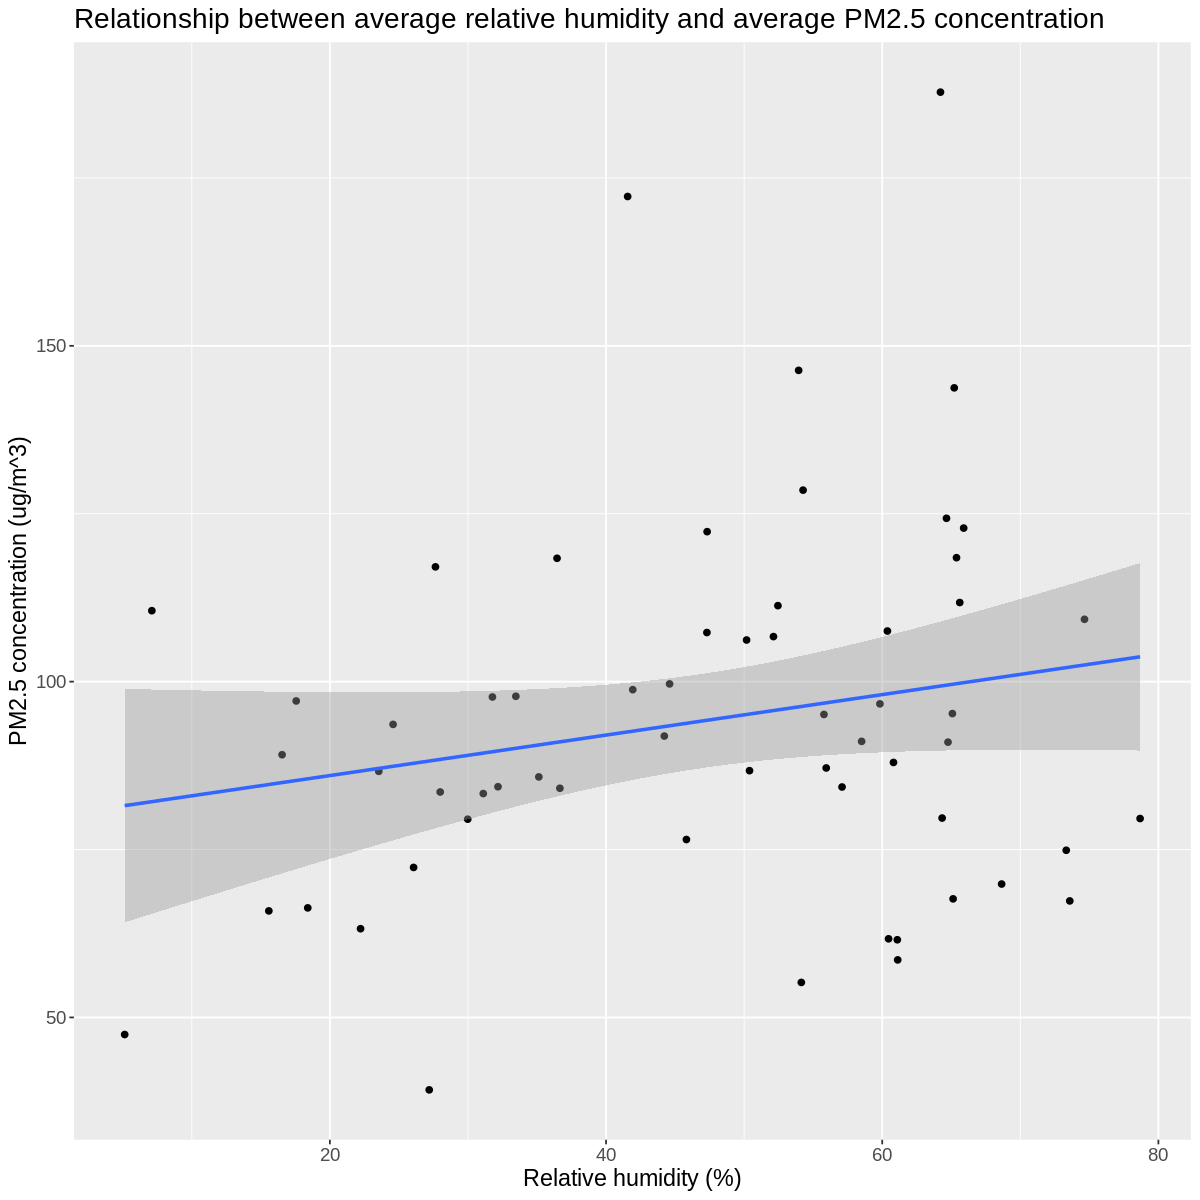

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



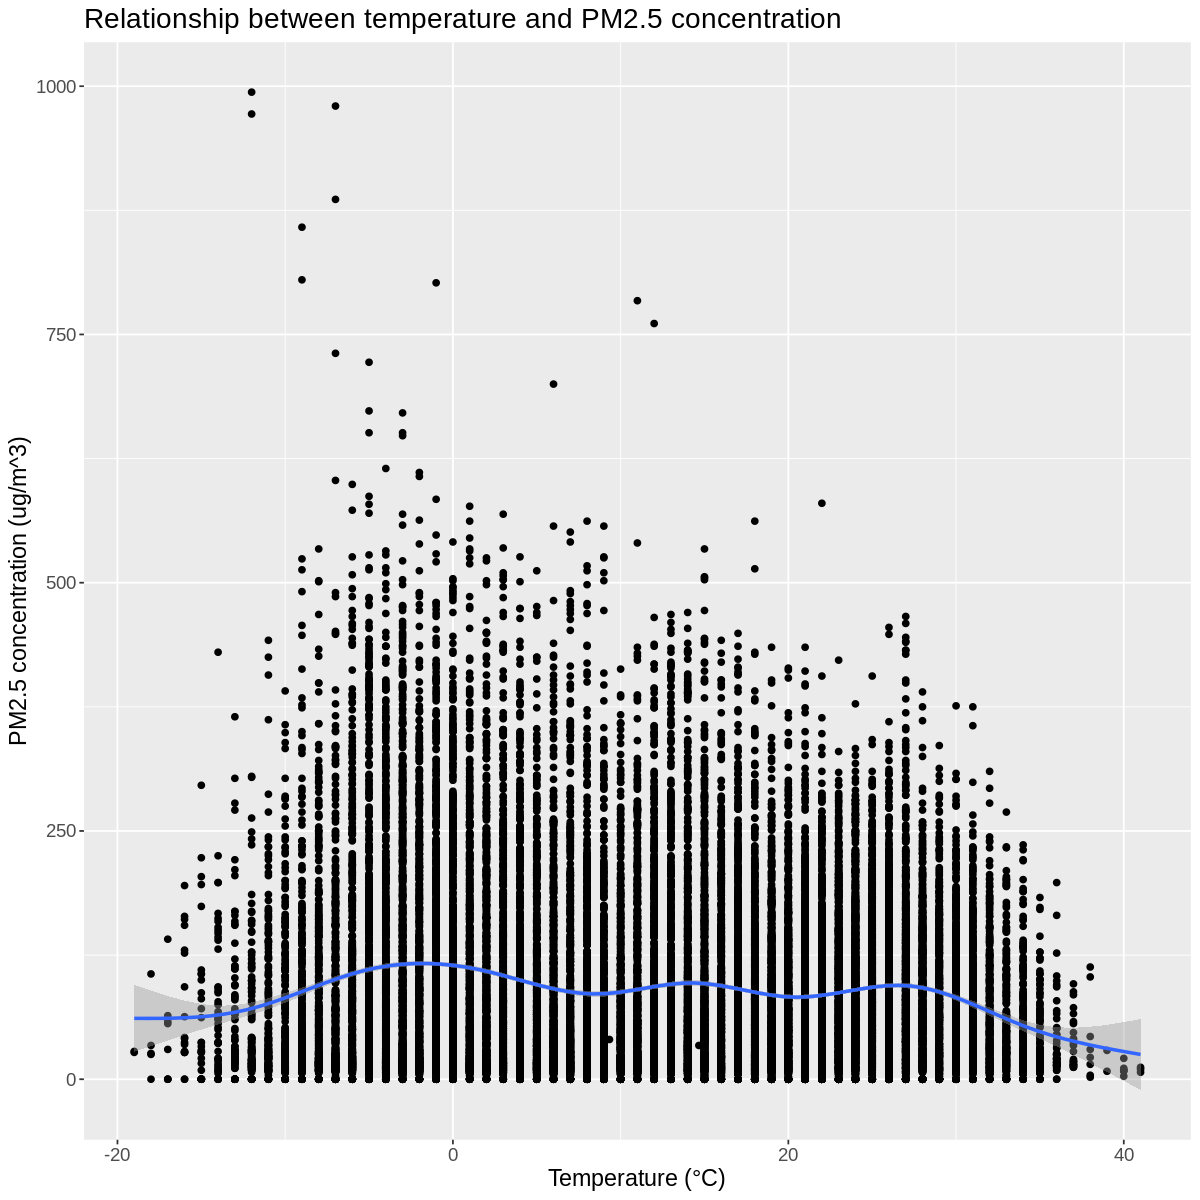

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



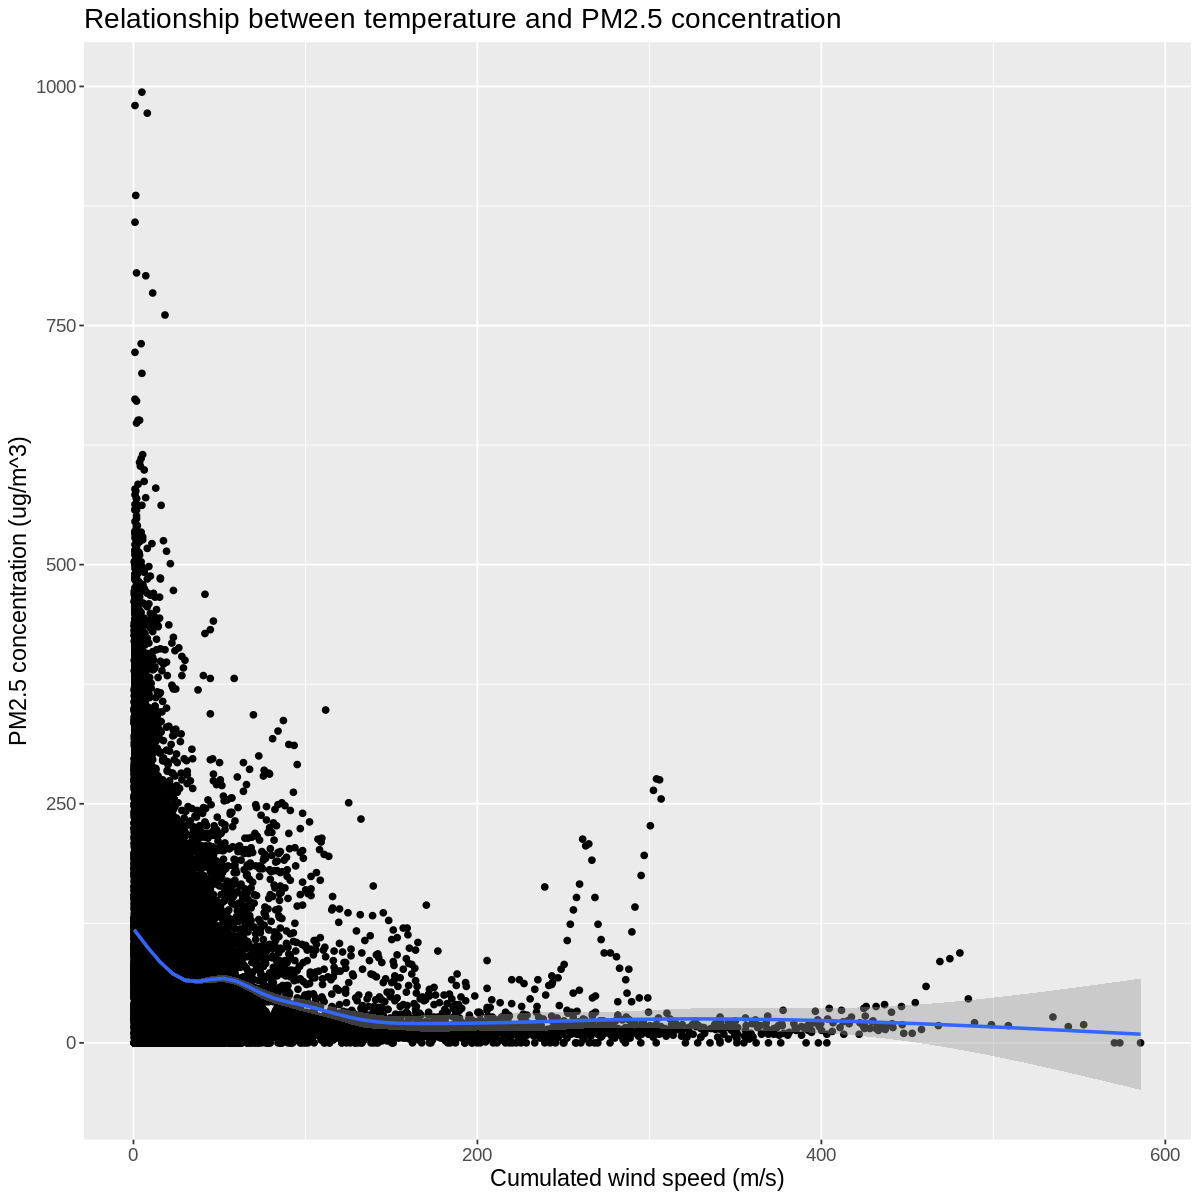

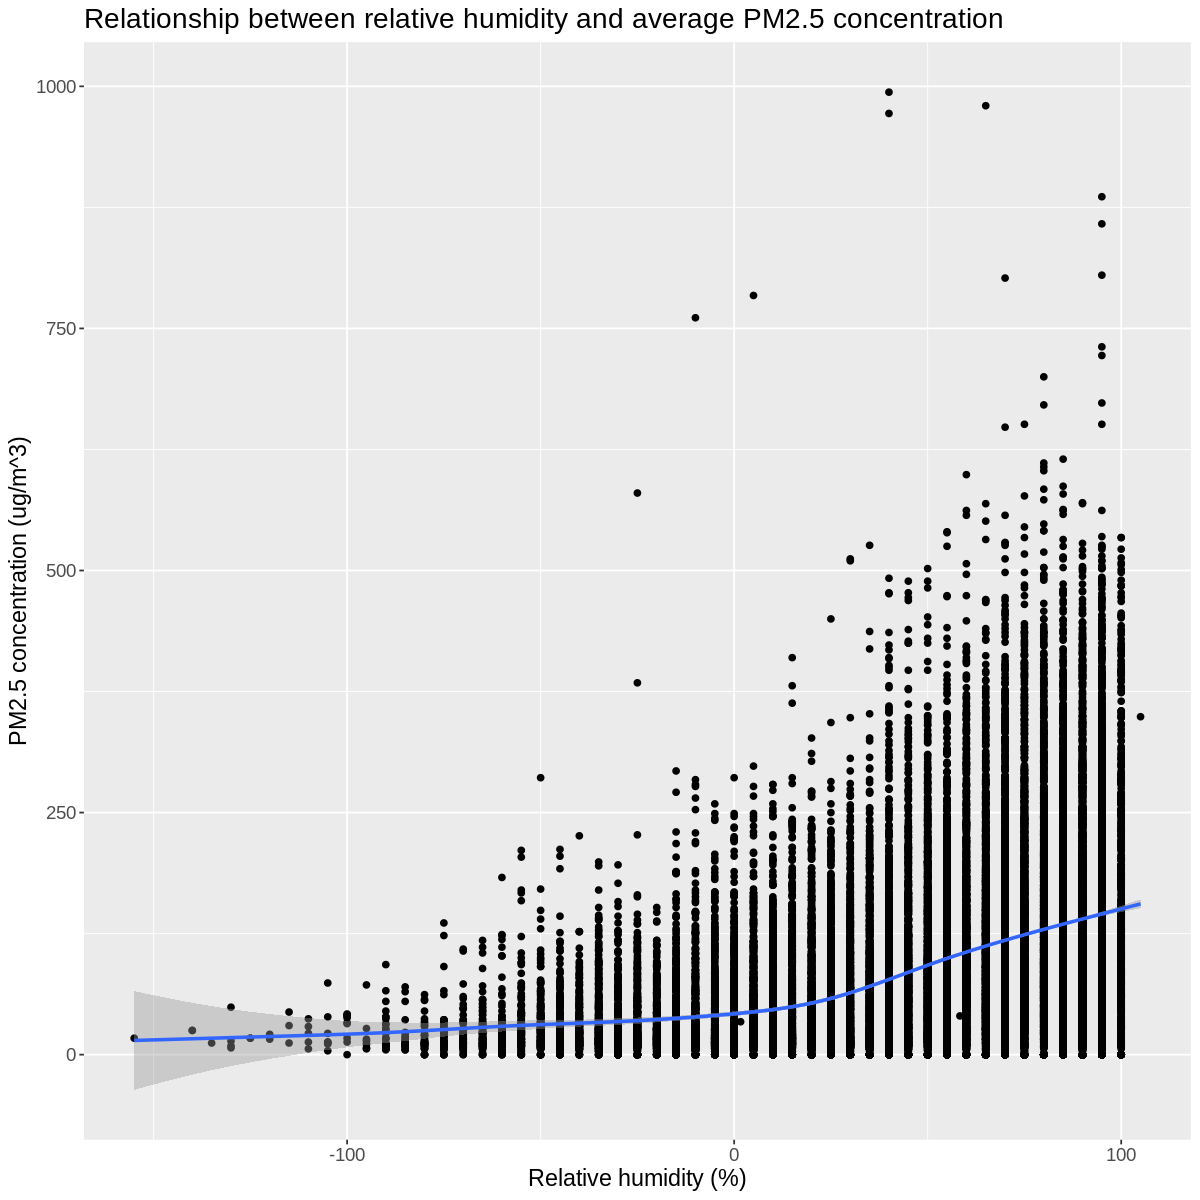

In [4]:
options(repr.plot.width = 10, repr.plot.height = 10)
TEMP_pm2.5_avg_plot <- ggplot(pollute_avg, aes(x = TEMP_avg,y = pm2.5_avg)) +
geom_point() +
geom_smooth(method="lm") +
ggtitle("Relationship between average temperature and average PM2.5 concentration") +
labs(x = "Temperature (°C)",y = "PM2.5 concentration (ug/m^3)") +
theme(text = element_text(size = 14))
TEMP_pm2.5_avg_plot

Iws_pm2.5_avg_plot <- ggplot(pollute_avg, aes(x = Iws_avg,y = pm2.5_avg)) +
geom_point() +
geom_smooth(method="lm") +
ggtitle("Relationship between average cumulated wind speed and average PM2.5 concentration") + 
labs(x = "Cumulated wind speed (m/s)",y = "PM2.5 concentration (ug/m^3)") +
theme(text = element_text(size = 14))
Iws_pm2.5_avg_plot

HUMID_pm2.5_avg_plot <- ggplot(pollute_avg, aes(x = HUMID_avg,y = pm2.5_avg)) +
geom_point() +
geom_smooth(method="lm") +
ggtitle("Relationship between average relative humidity and average PM2.5 concentration") + 
labs(x = "Relative humidity (%)",y = "PM2.5 concentration (ug/m^3)") +
theme(text = element_text(size = 14))
HUMID_pm2.5_avg_plot

TEMP_pm2.5_total_plot <- ggplot(pollution_training, aes(x = TEMP,y = pm2.5)) +
geom_point() +
geom_smooth() +
ggtitle("Relationship between temperature and PM2.5 concentration") +
labs(x = "Temperature (°C)",y = "PM2.5 concentration (ug/m^3)") +
theme(text = element_text(size = 14))
TEMP_pm2.5_total_plot

Iws_pm2.5_total_plot <- ggplot(pollution_training, aes(x = Iws,y = pm2.5)) +
geom_point() +
geom_smooth() +
ggtitle("Relationship between temperature and PM2.5 concentration") +
labs(x = "Cumulated wind speed (m/s)",y = "PM2.5 concentration (ug/m^3)") +
theme(text = element_text(size = 14))
Iws_pm2.5_total_plot

HUMID_pm2.5_avg_plot <- ggplot(pollution_training, aes(x = HUMID,y = pm2.5)) +
geom_point() +
geom_smooth() +
ggtitle("Relationship between relative humidity and average PM2.5 concentration") + 
labs(x = "Relative humidity (%)",y = "PM2.5 concentration (ug/m^3)") +
theme(text = element_text(size = 14))
HUMID_pm2.5_avg_plot

`summarise()` regrouping output by 'year', 'month' (override with `.groups` argument)



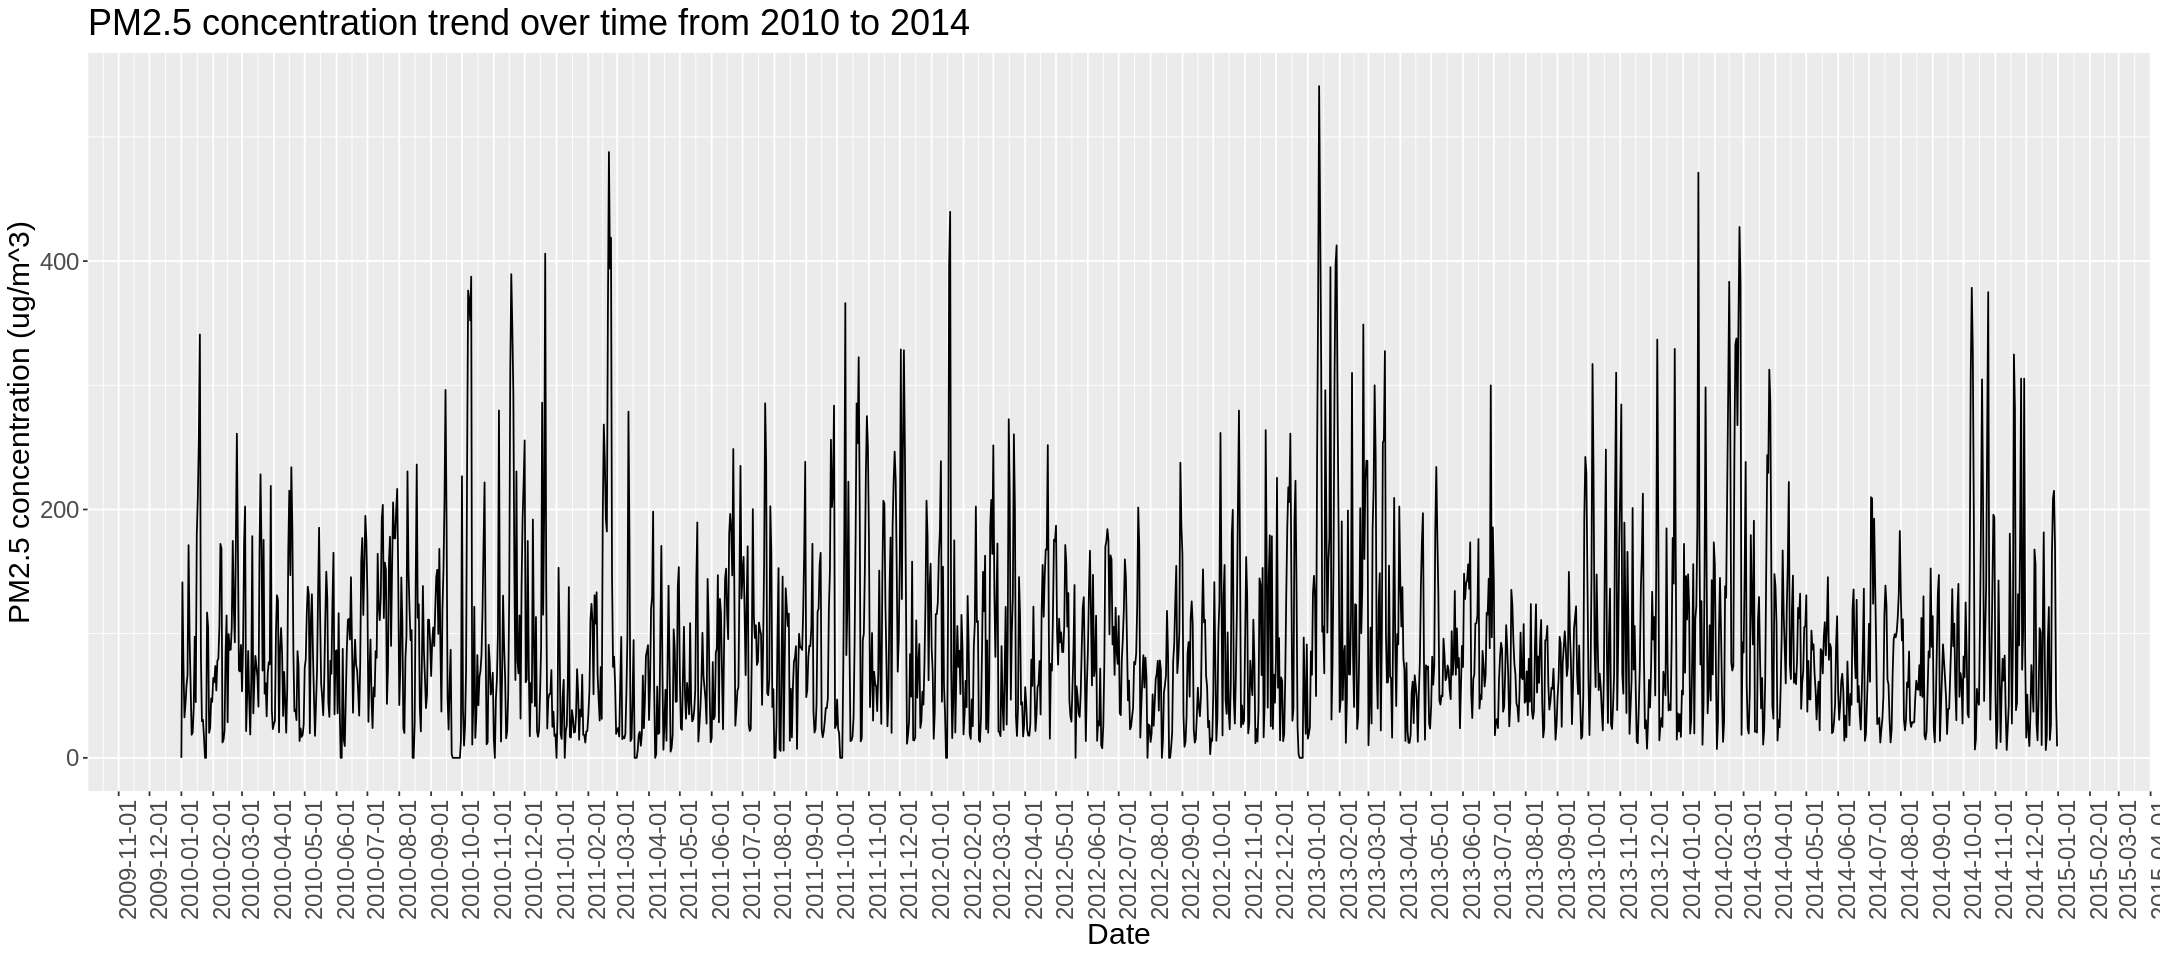

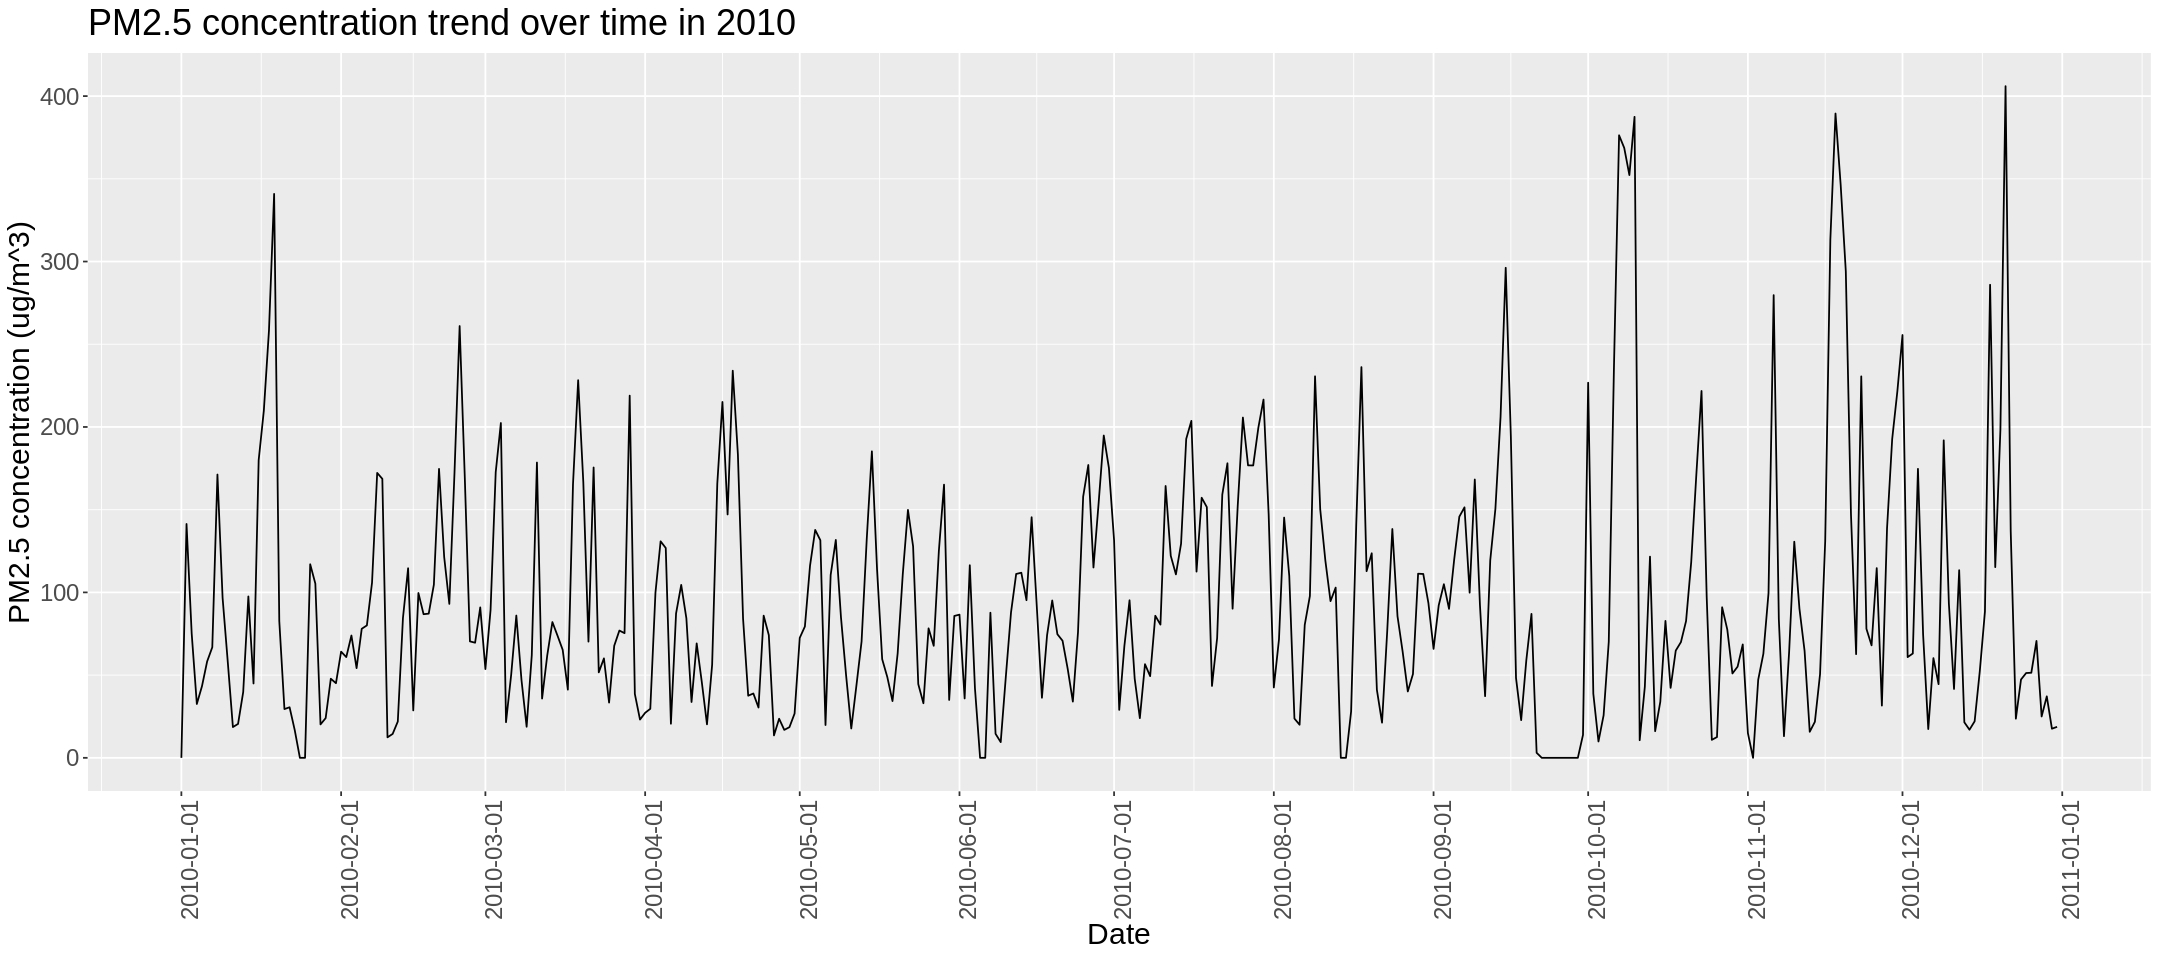

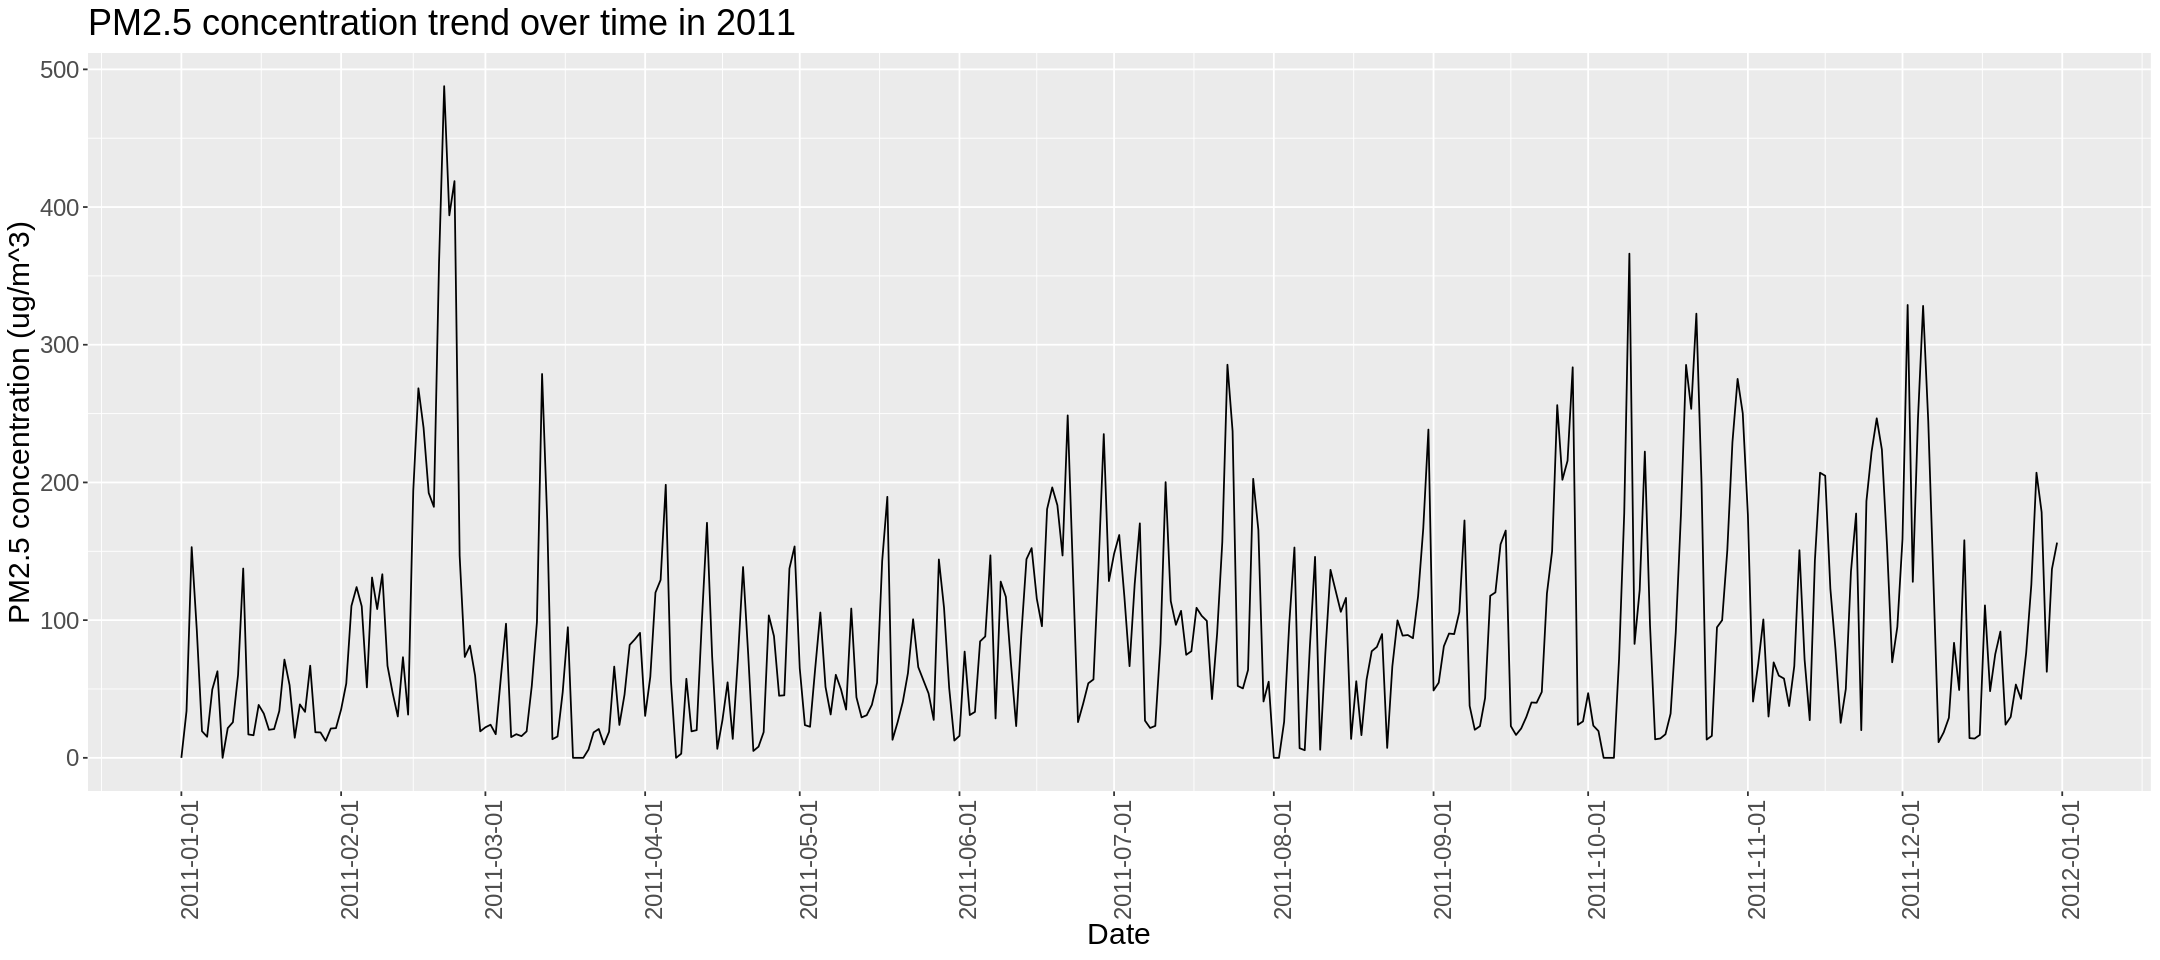

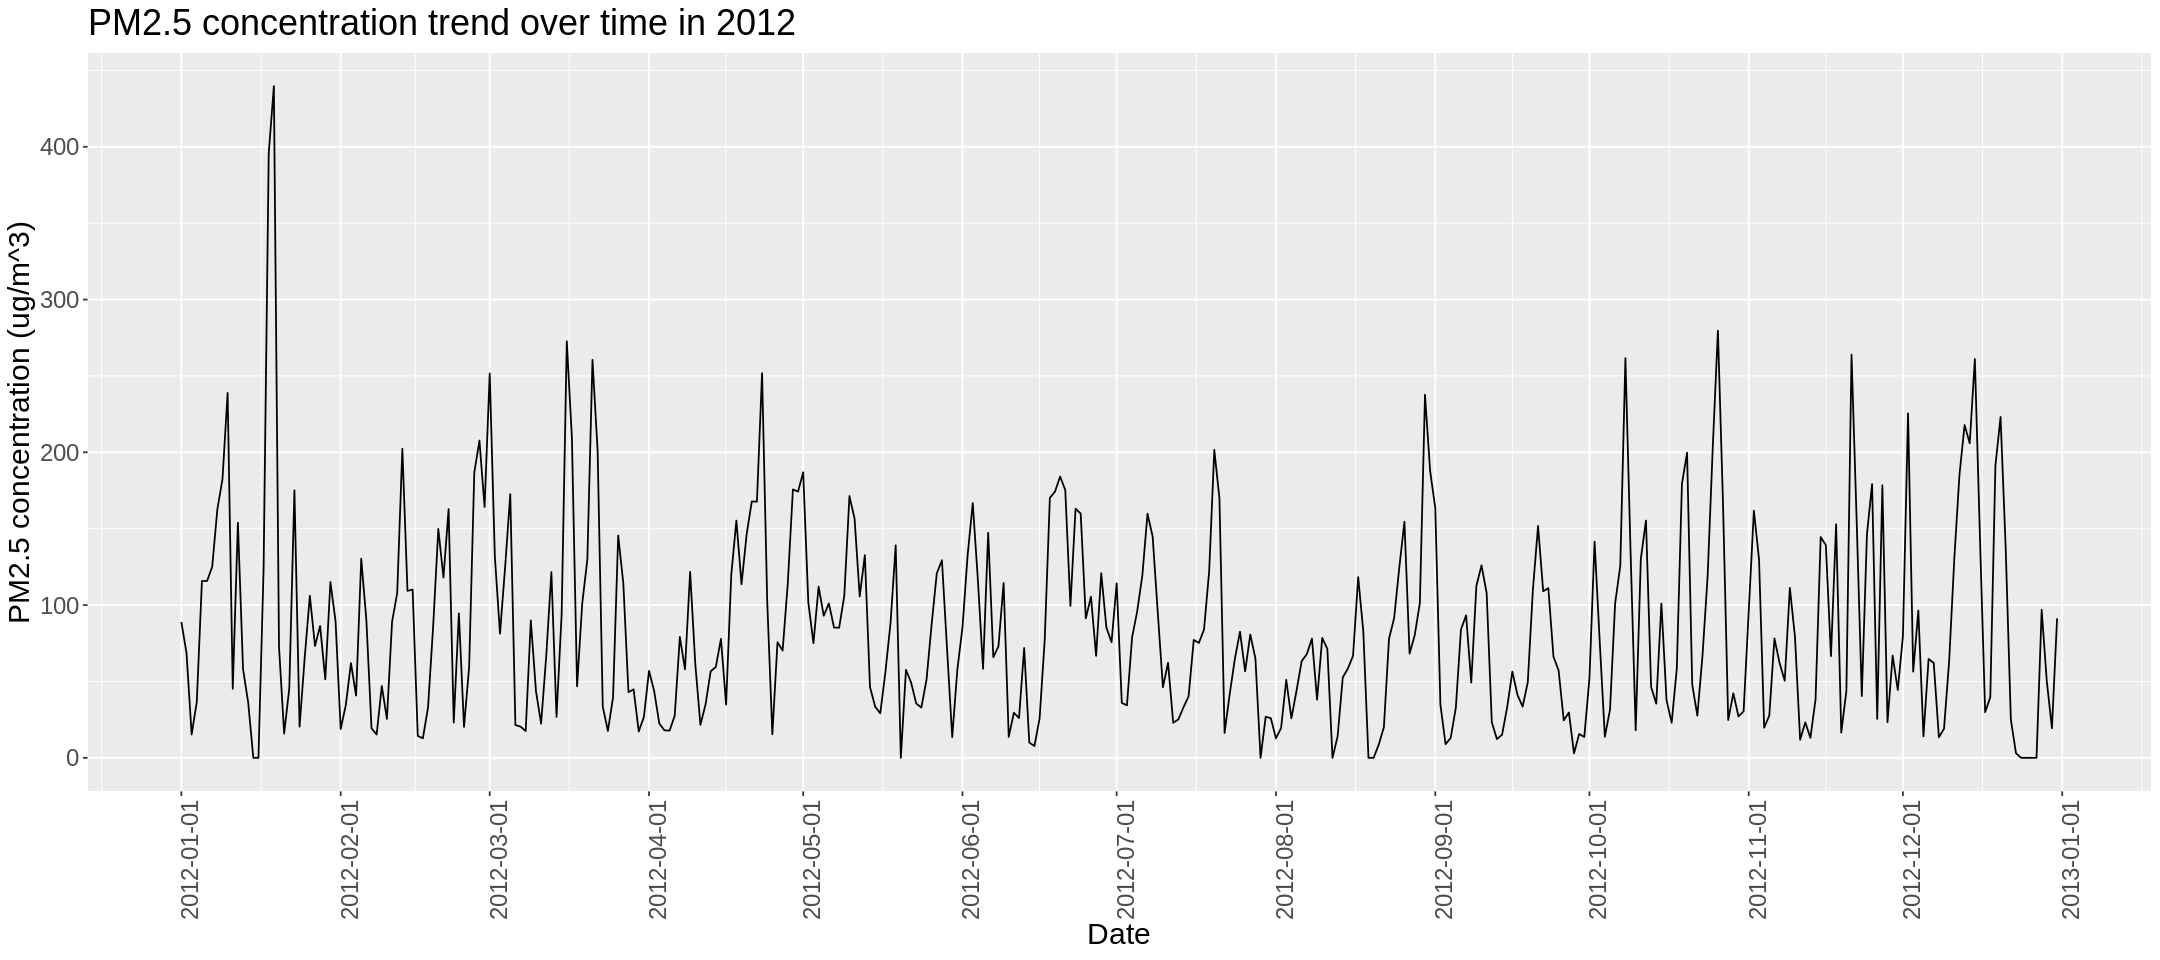

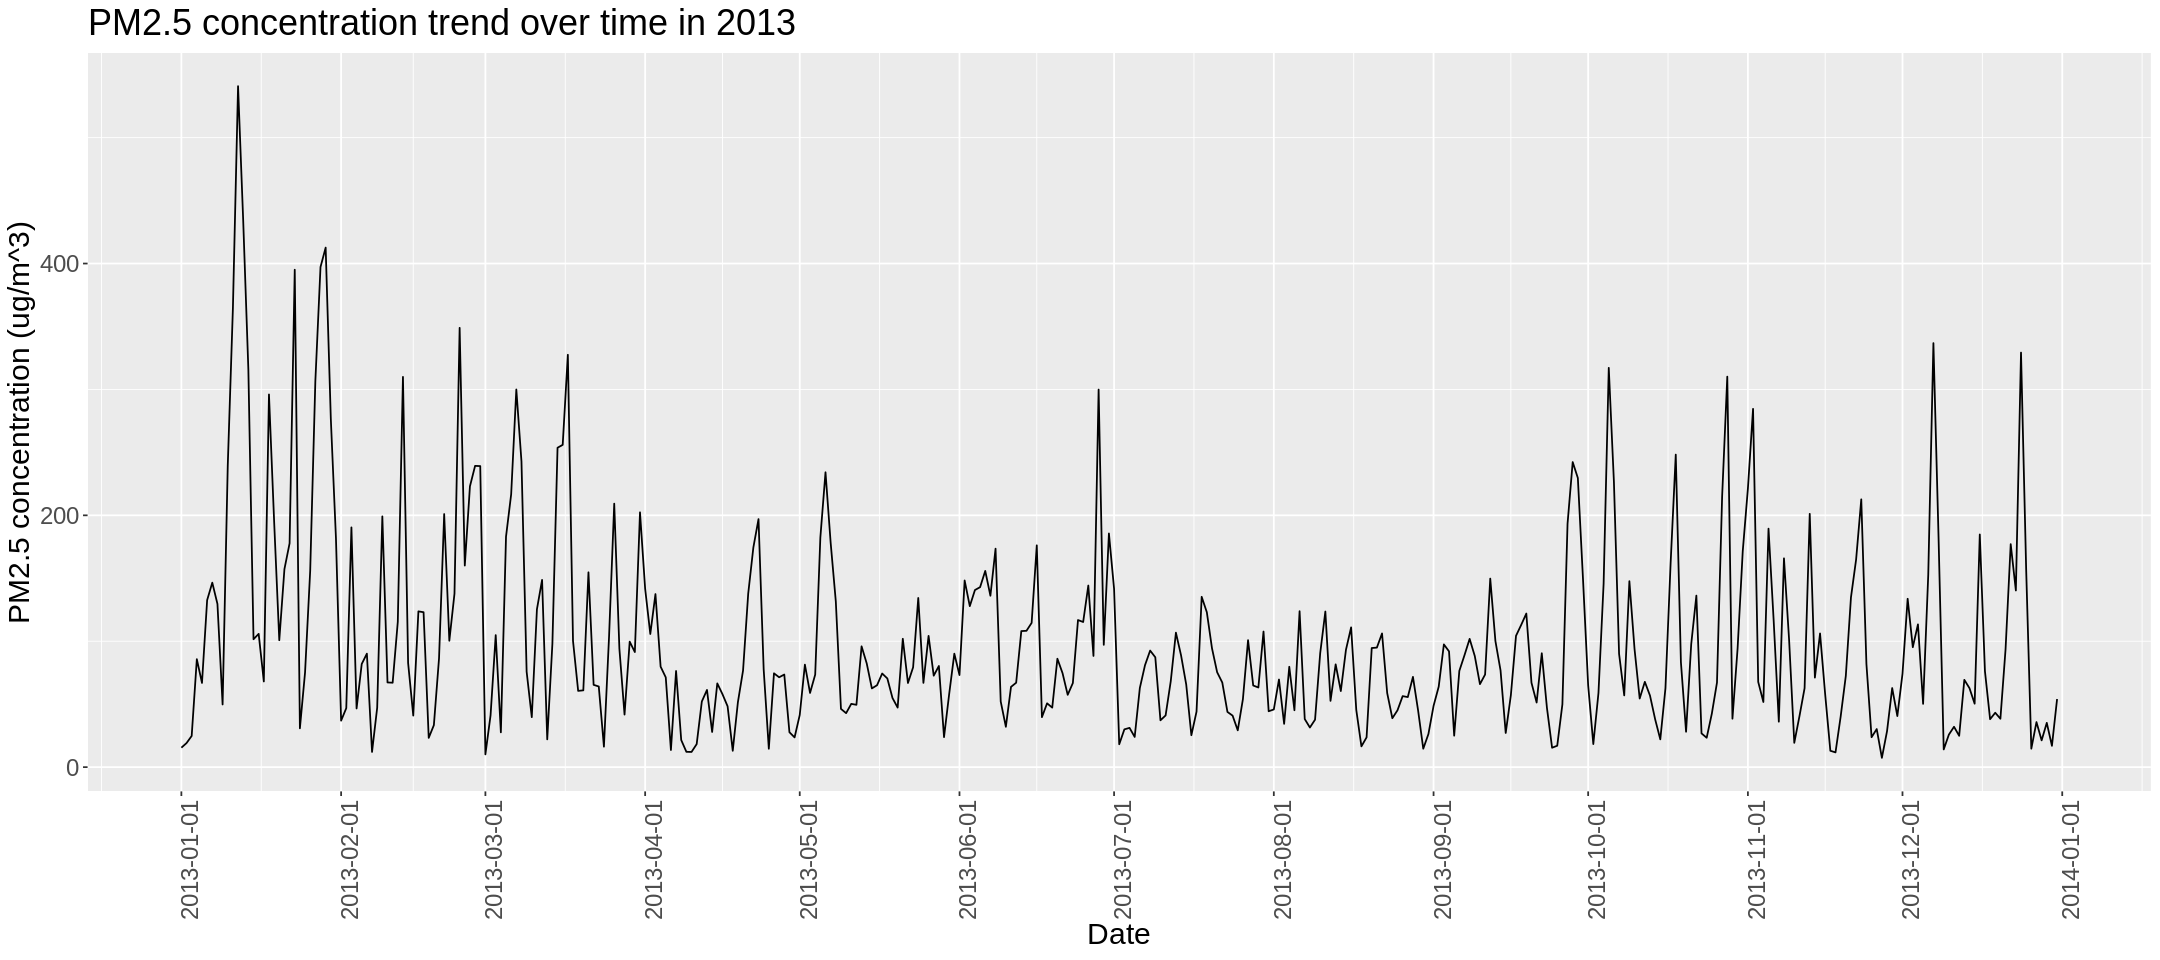

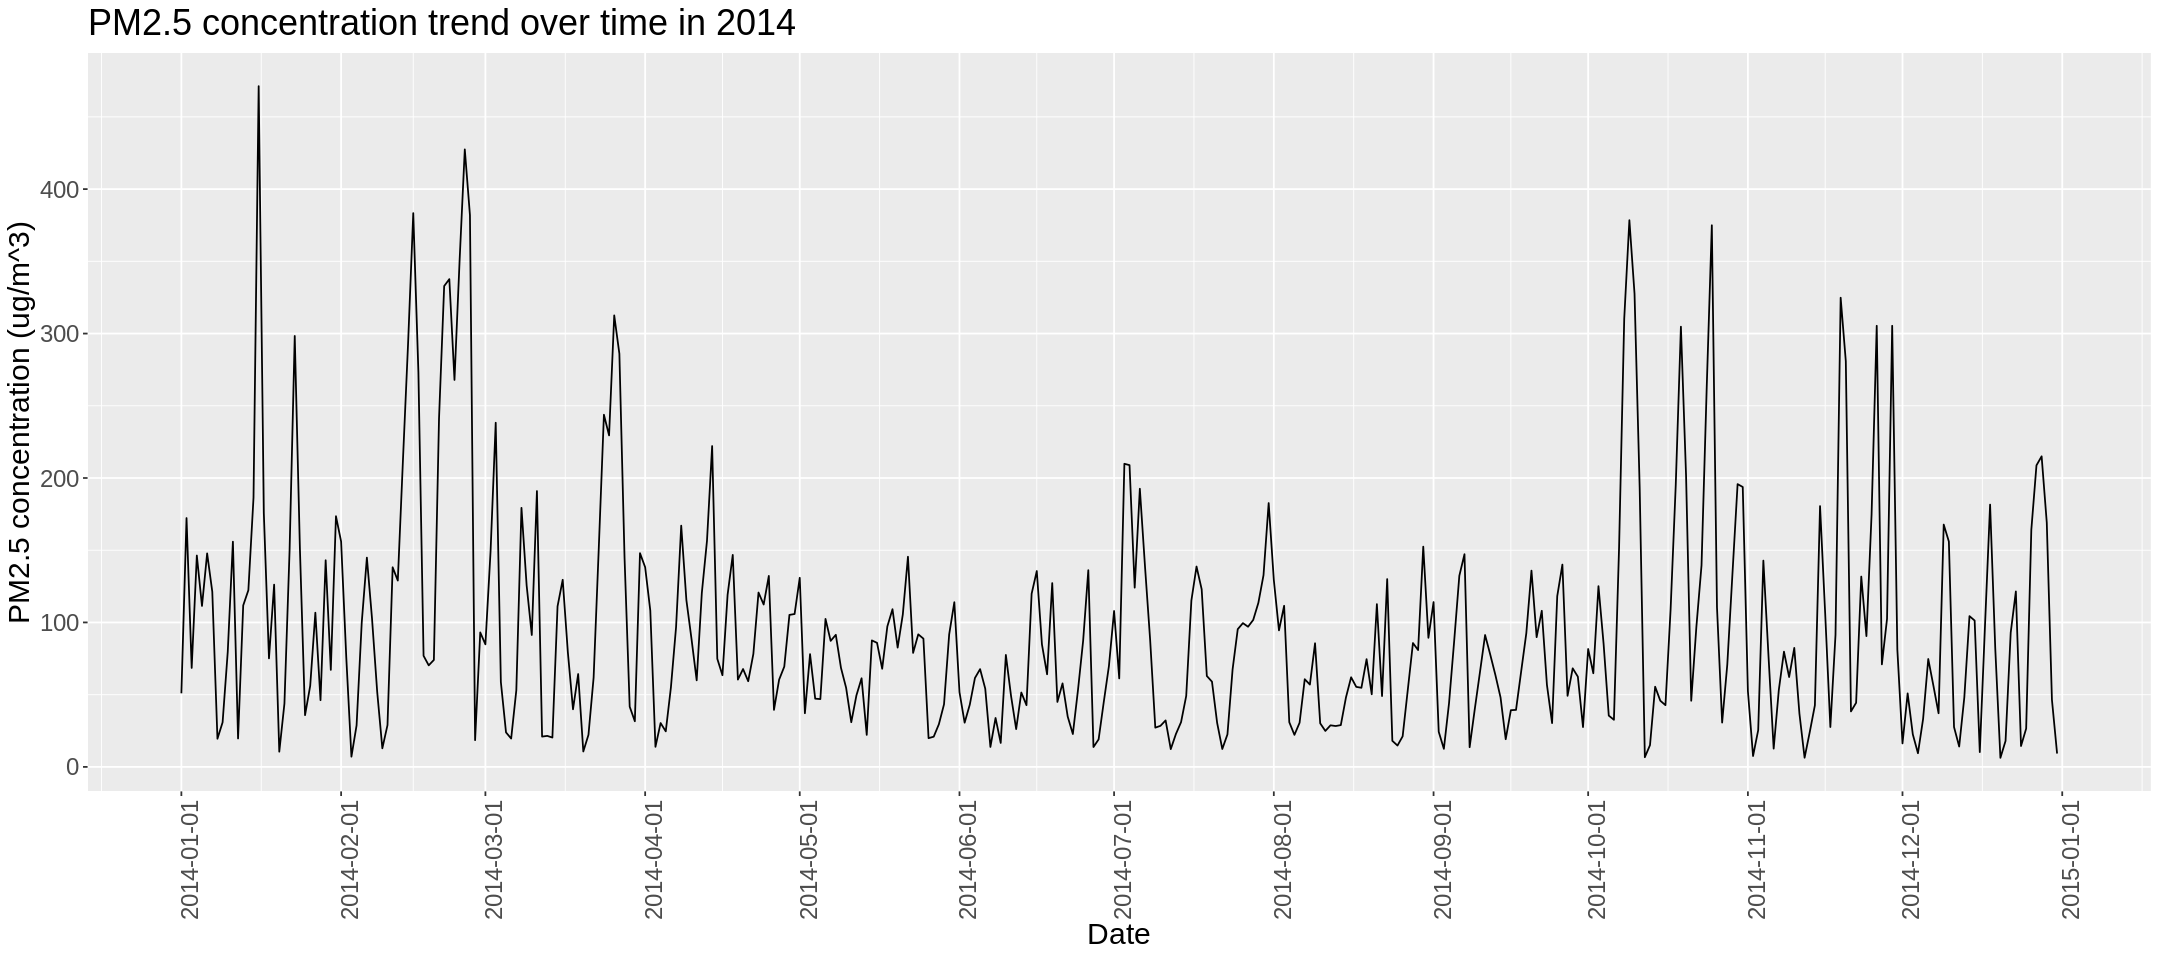

In [20]:
options(repr.plot.width = 18, repr.plot.height = 8)
pm2.5_data <- pollution_training %>%
    select(year,month,day,pm2.5) %>%
    group_by(year,month,day) %>%
    summarise(pm2.5_avg = mean(pm2.5, na.rm = TRUE))
pm2.5_data$Date<-as.Date(with(pm2.5_data,paste(year,month,day,sep="-")),"%Y-%m-%d")

pm2.5_time_total_plot <- ggplot(pm2.5_data, aes(x = Date, y = pm2.5_avg)) + 
     geom_line() +
     xlab("Date") +
     ylab("PM2.5 concentration (ug/m^3)") + 
    scale_x_date(date_breaks = "1 month") +
    ggtitle("PM2.5 concentration trend over time from 2010 to 2014") +
     theme(axis.text.x = element_text(angle = 90, hjust = 1), text = element_text(size = 18)) 
pm2.5_time_total_plot

pm2.5_time_2010_plot <- pm2.5_data %>%
filter(year == 2010) %>%
ggplot(aes(x = Date, y = pm2.5_avg)) + 
     geom_line() +
     xlab("Date") +
     ylab("PM2.5 concentration (ug/m^3)") + 
    scale_x_date(date_breaks = "1 month") + 
    ggtitle("PM2.5 concentration trend over time in 2010") +
     theme(axis.text.x = element_text(angle = 90, hjust = 1), text = element_text(size = 18)) 
pm2.5_time_2010_plot

pm2.5_time_2011_plot <- pm2.5_data %>%
filter(year == 2011) %>%
ggplot(aes(x = Date, y = pm2.5_avg)) + 
     geom_line() +
     xlab("Date") +
     ylab("PM2.5 concentration (ug/m^3)") + 
    scale_x_date(date_breaks = "1 month") + 
    ggtitle("PM2.5 concentration trend over time in 2011") +
     theme(axis.text.x = element_text(angle = 90, hjust = 1), text = element_text(size = 18)) 
pm2.5_time_2011_plot

pm2.5_time_2012_plot <- pm2.5_data %>%
filter(year == 2012) %>%
ggplot(aes(x = Date, y = pm2.5_avg)) + 
     geom_line() +
     xlab("Date") +
     ylab("PM2.5 concentration (ug/m^3)") + 
    scale_x_date(date_breaks = "1 month") +
    ggtitle("PM2.5 concentration trend over time in 2012") +
     theme(axis.text.x = element_text(angle = 90, hjust = 1), text = element_text(size = 18)) 
pm2.5_time_2012_plot

pm2.5_time_2013_plot <- pm2.5_data %>%
filter(year == 2013) %>%
ggplot(aes(x = Date, y = pm2.5_avg)) + 
     geom_line() +
     xlab("Date") +
     ylab("PM2.5 concentration (ug/m^3)") + 
     ggtitle("PM2.5 concentration trend over time in 2013") +
    scale_x_date(date_breaks = "1 month") + # labels every month
     theme(axis.text.x = element_text(angle = 90, hjust = 1), text = element_text(size = 18)) 
pm2.5_time_2013_plot

pm2.5_time_2014_plot <- pm2.5_data %>%
filter(year == 2014) %>%
ggplot(aes(x = Date, y = pm2.5_avg)) + 
     geom_line() +
     xlab("Date") +
     ylab("PM2.5 concentration (ug/m^3)") + 
    scale_x_date(date_breaks = "1 month") +
    ggtitle("PM2.5 concentration trend over time in 2014") +
     theme(axis.text.x = element_text(angle = 90, hjust = 1), text = element_text(size = 18)) 
pm2.5_time_2014_plot

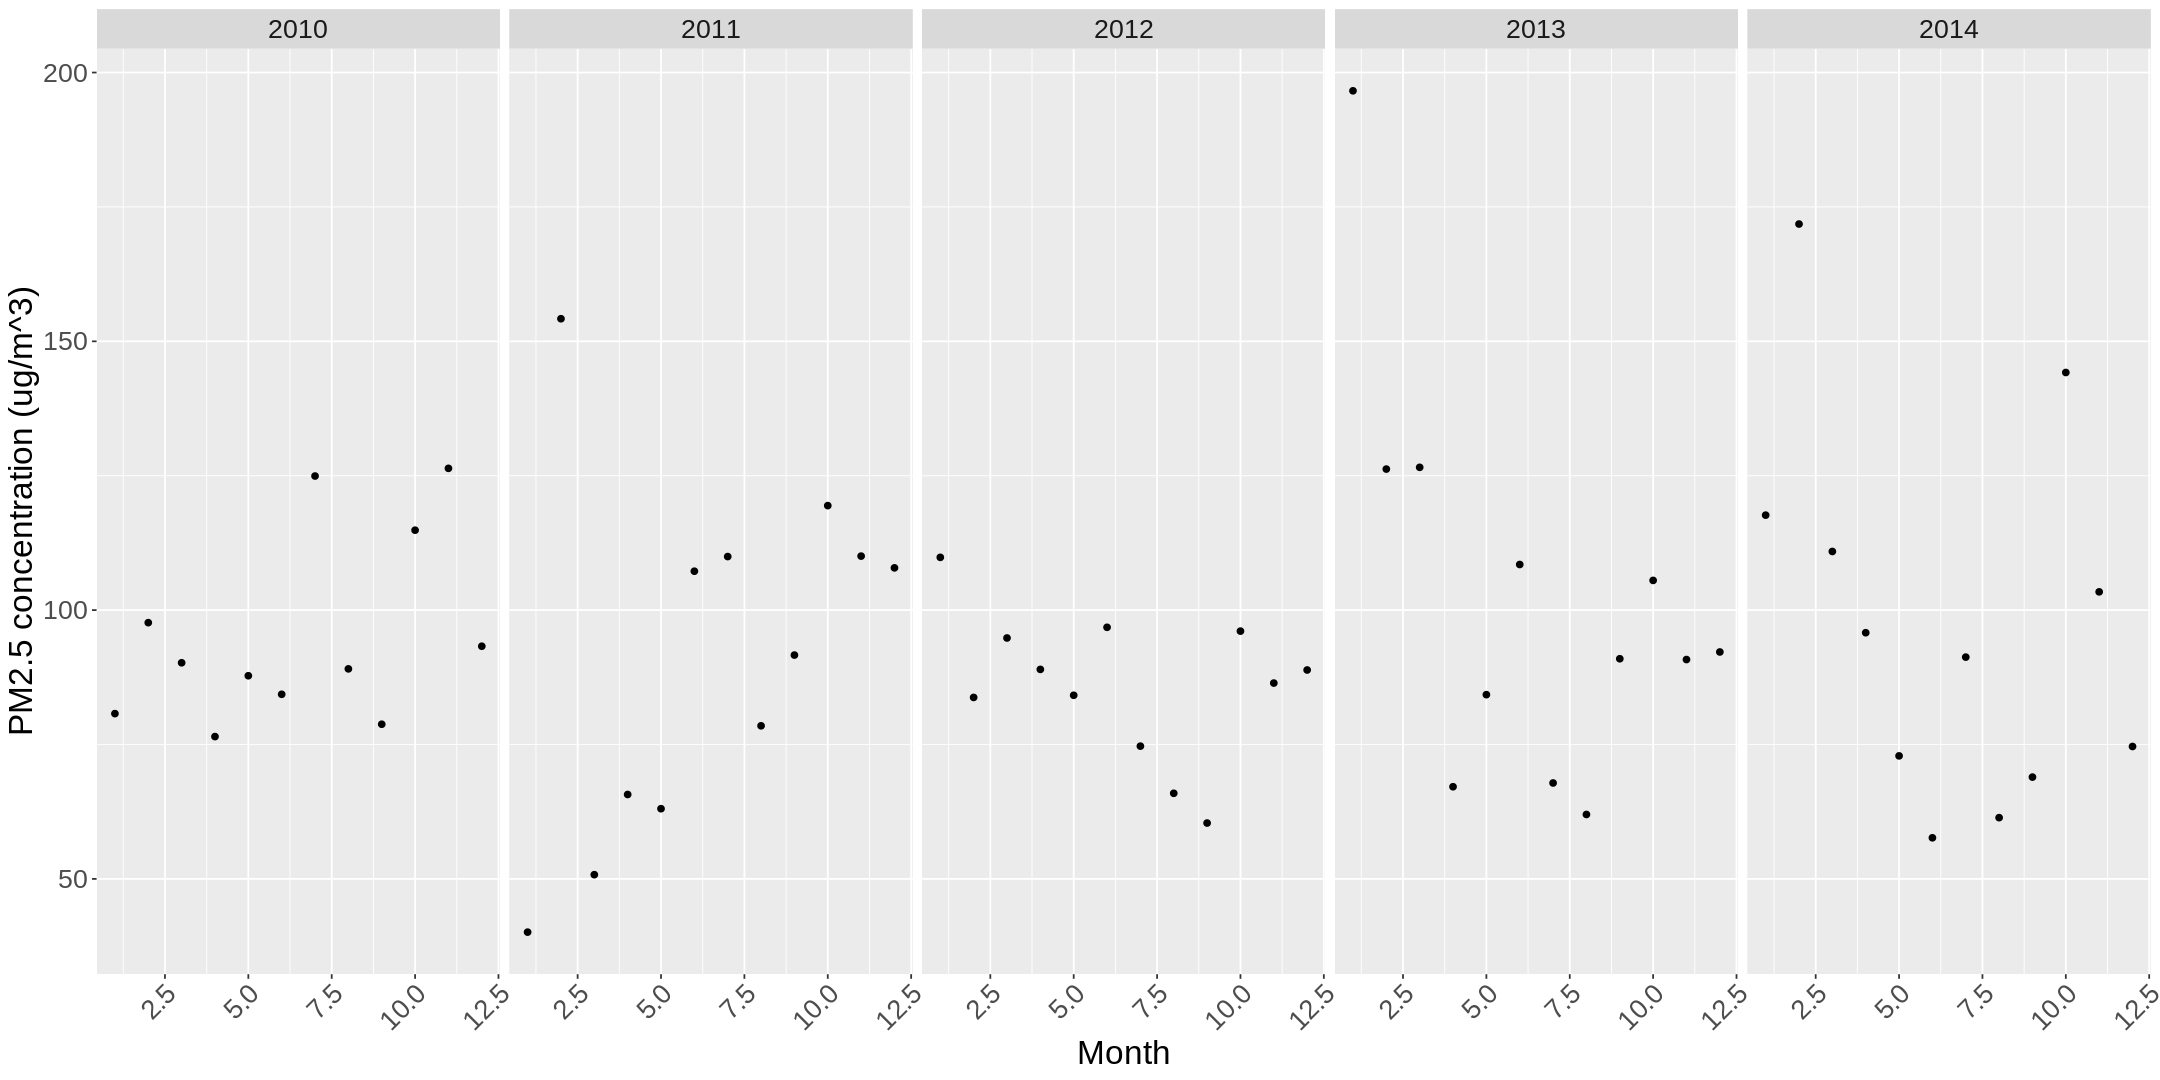

In [22]:
options(repr.plot.width = 18, repr.plot.height = 9)
pm2.5_avg_plot <- pollute_avg %>%
    ggplot(aes(x = month, y = pm2.5_avg)) + 
    geom_point() +
    xlab("Month") + 
    ylab("PM2.5 concentration (ug/m^3)") +
    facet_grid(.~ year) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
         strip.text.y.left = element_text(angle = 0),
         text = element_text(size = 20))
pm2.5_avg_plot

## Conclusion
We expect to find the strength of the relationships between the three predictors and PM 2.5. Our findings will provide good suggestions as to whether residents in Beijing can do outdoor activities under different conditions. However, one further question that we want to ask is whether different locations in Beijing lead to different PM 2.5 concentrations. Other factors that could affect PM2.5 concentration that should also be accounted for are the air pressure of the area and rainfall. The question is expected to be answered in the future as we do not have location data in our current dataset, nor do we have sufficient data to account for other potential factors. 

## Citations:
- “California Air Resources Board.” Inhalable Particulate Matter and Health (PM2.5 and PM10) | California Air Resources Board, https://ww2.arb.ca.gov/resources/inhalable-particulate-matter-and-health#:~:text=For%20PM2.,symptoms%2C%20and%20restricted%20activity%20days. 
- Liang, X., Zou, T., Guo, B., Li, S., Zhang, H., Zhang, S., Huang, H. and Chen, S. X. (2015). Assessing Beijing's PM2.5 pollution: severity, weather impact, APEC and winter heating. Proceedings of the Royal Society A, 471, 20150257.
- Sun, Ruiling, et al. “Influencing Factors of PM2.5 Pollution: Disaster Points of Meteorological Factors.” International Journal of Environmental Research and Public Health, MDPI, 14 Oct. 2019, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6843796/. 